# Test Recurrent Policy with Extreme Parameter Variation 

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Asteroid3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_Meta-Learning-master/Experiments/Asteroid_3DOF/Asteroid_PV_sphere


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
Glideslope Constraint: delta =  3
Flat Constraint


<IPython.core.display.Javascript object>


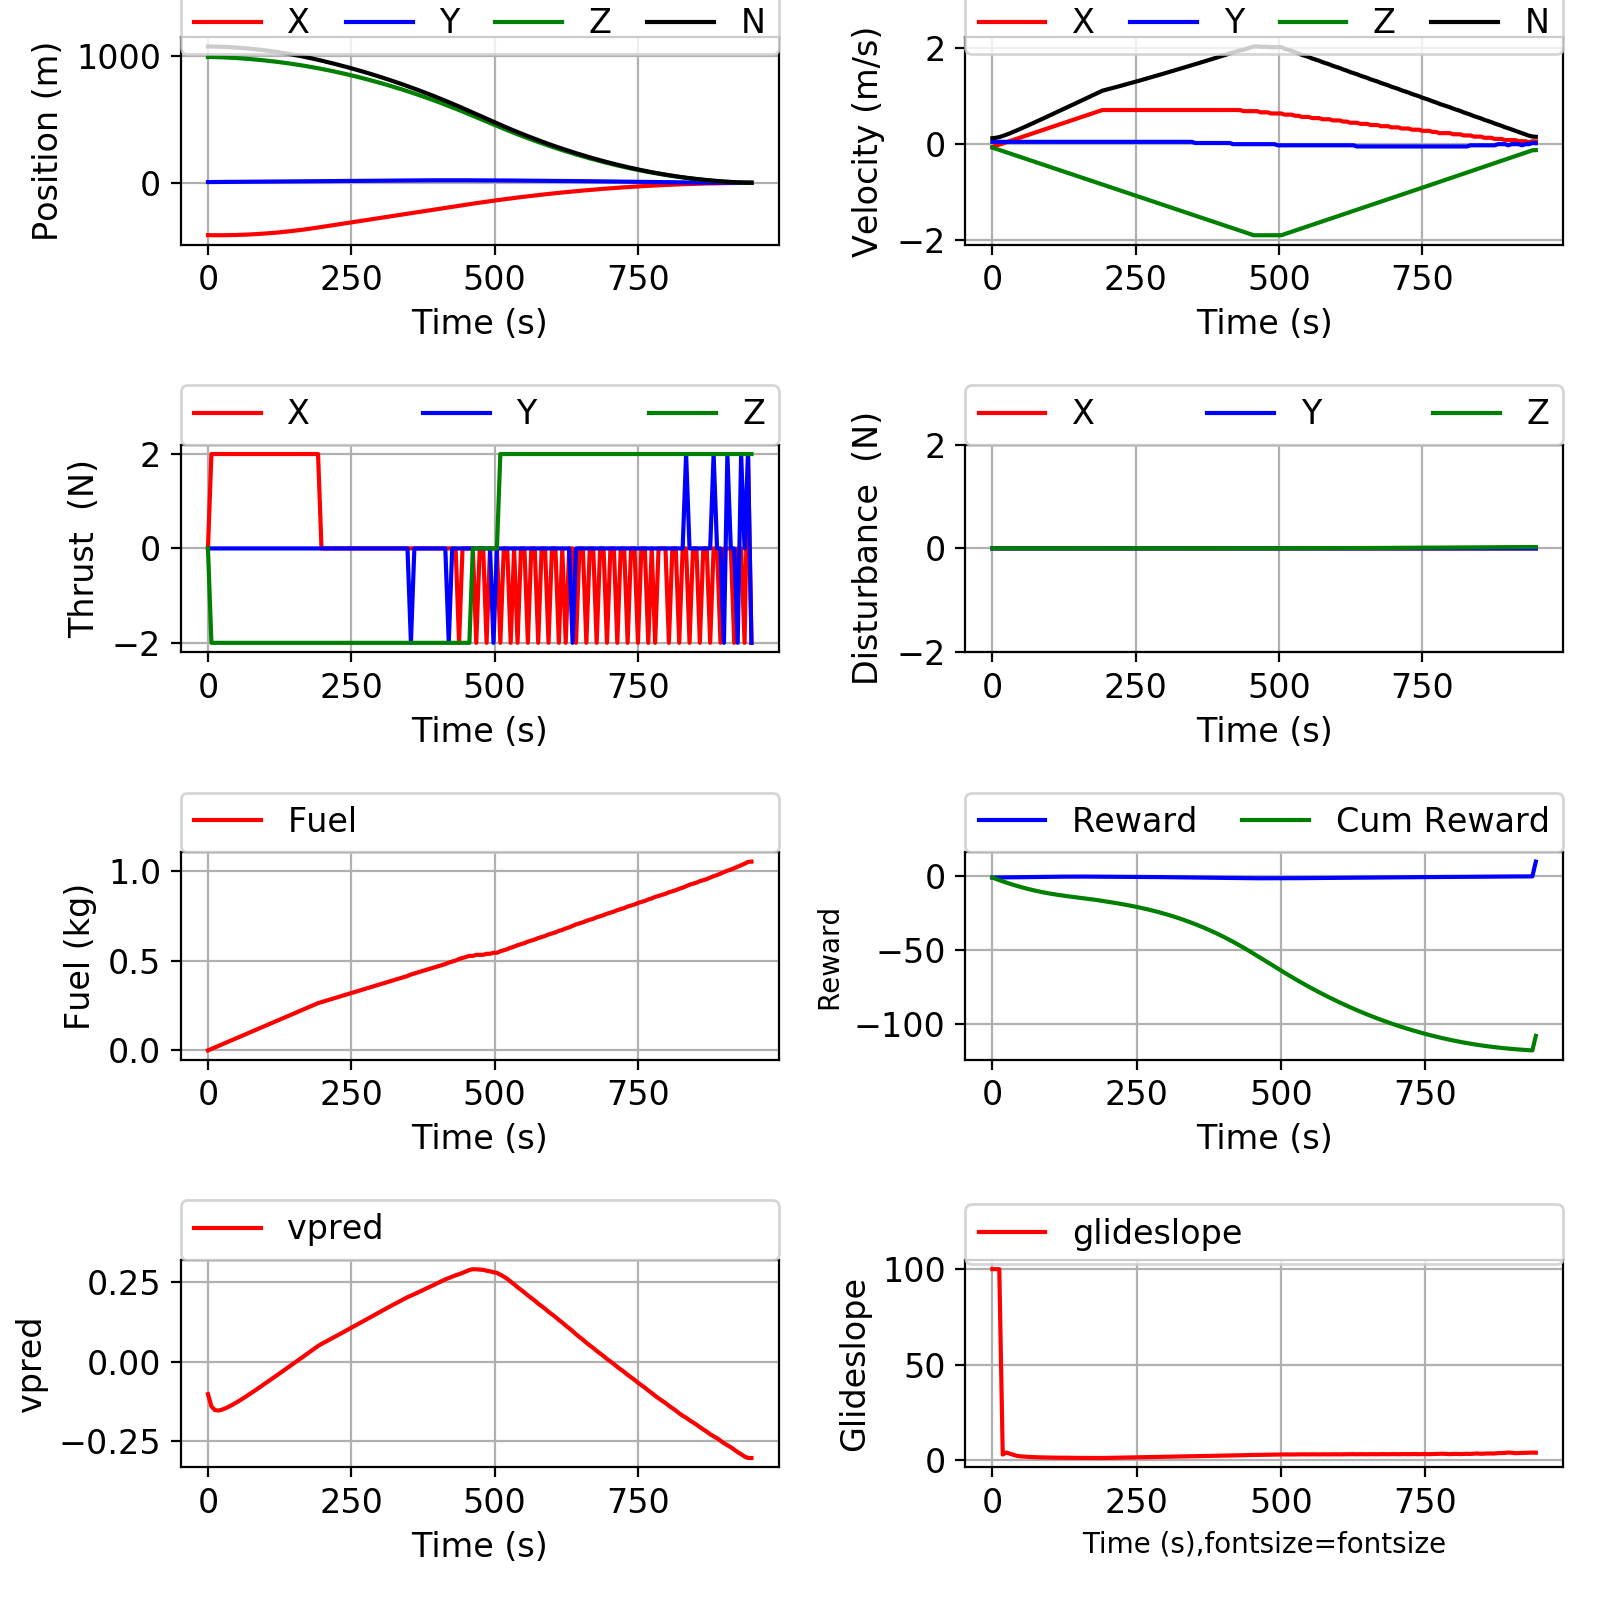

<IPython.core.display.Javascript object>


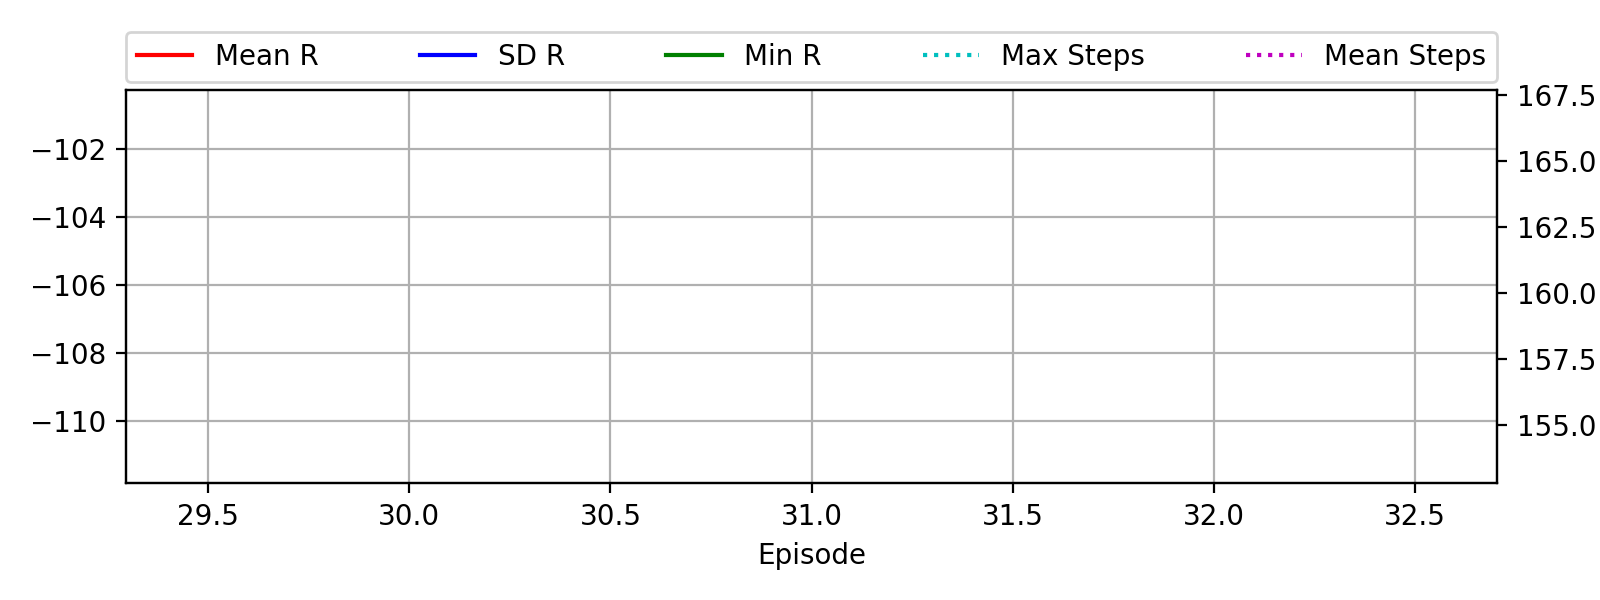

<IPython.core.display.Javascript object>


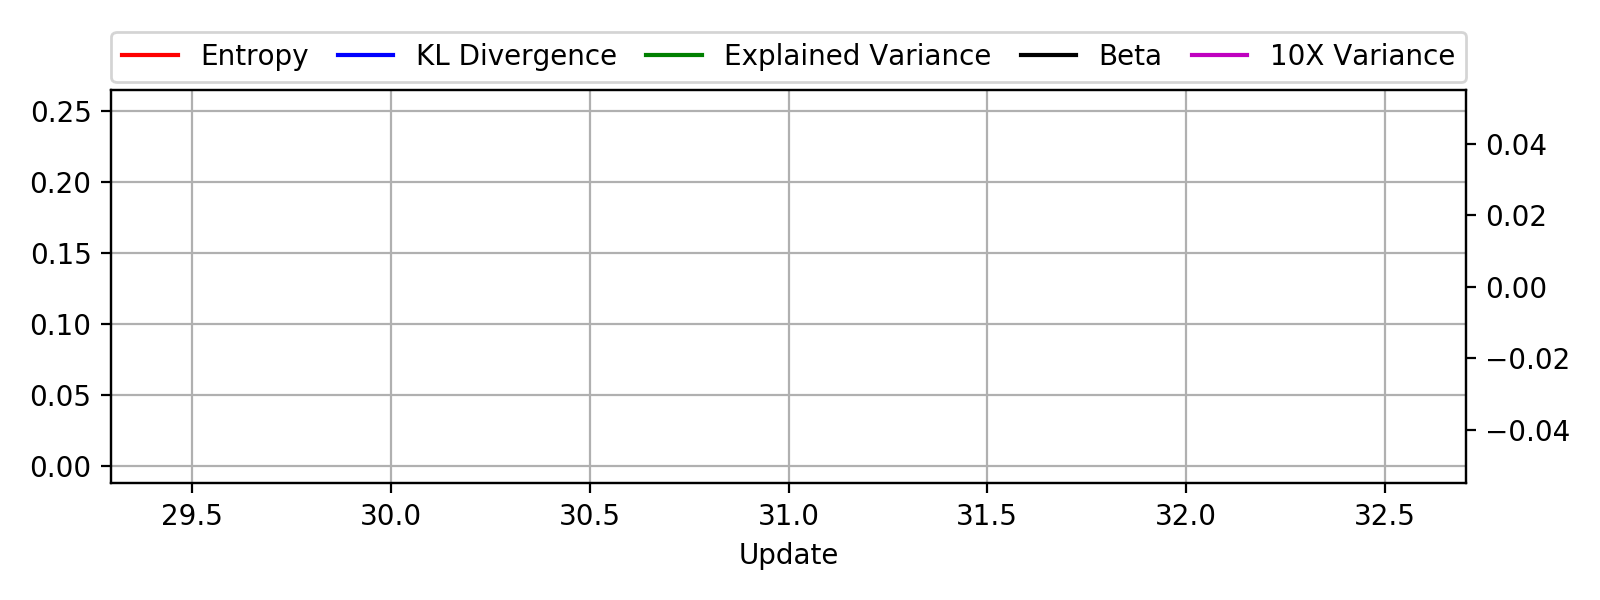

<IPython.core.display.Javascript object>


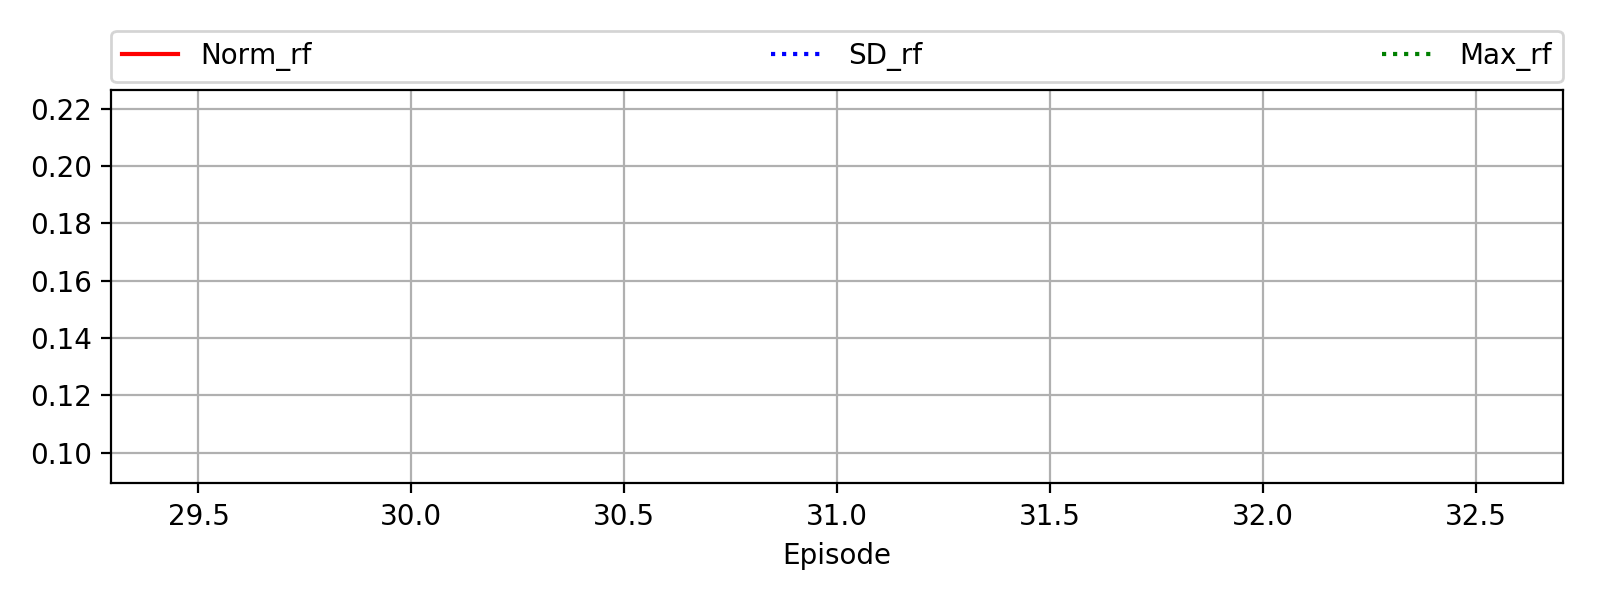

<IPython.core.display.Javascript object>


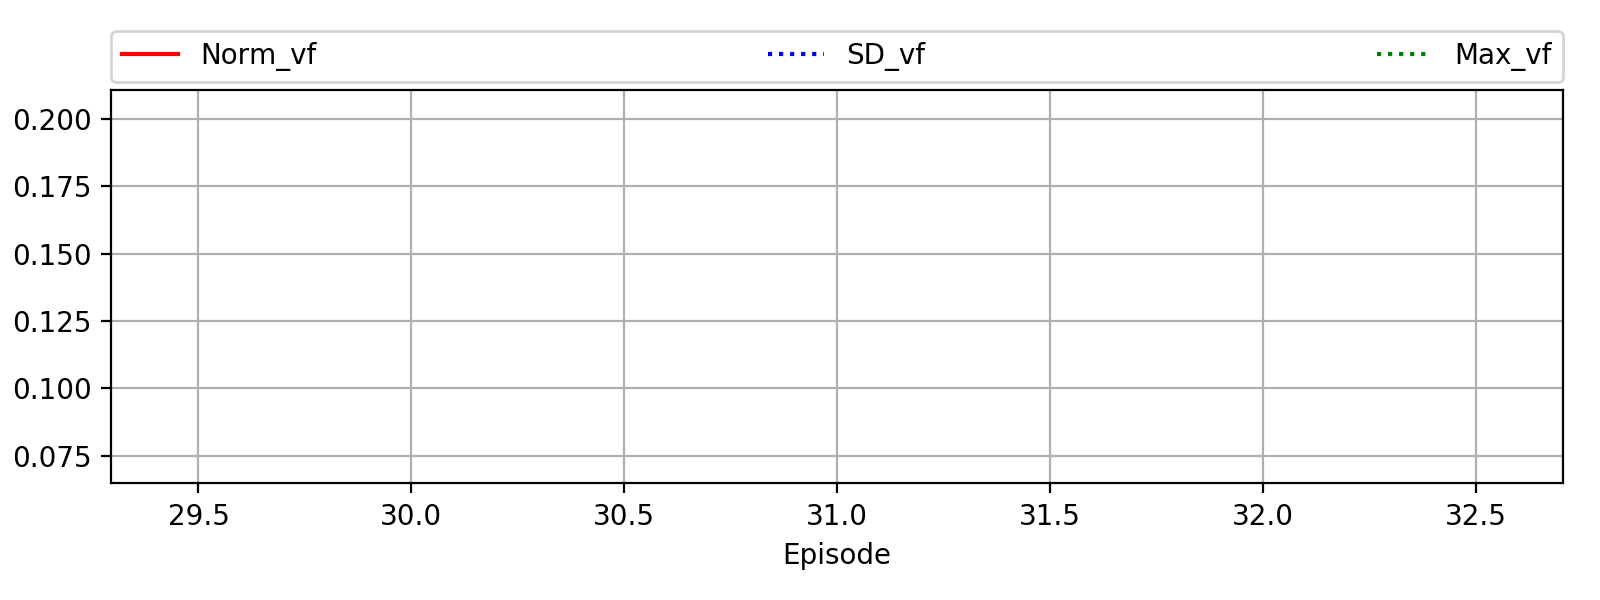

Lander Env
Landing_icgen:
    adjust_apf_v0               :  False
    w (min/max)                 :  (-0.0, -0.0, -0.0) (0.0, 0.0, 0.0)
 mass (min/max)                 :  450 500
  srp (min/max)                 :  (-1e-06, -1e-06, -1e-06) (1e-06, 1e-06, 1e-06)
M (min/max)                     :  (20000000000.0, 200000000000.0)
Position Theta                  :  (0, 0.7853981633974483)
Position Phi                    :  (-3.141592653589793, 3.141592653589793)
[[-1.]
 [ 0.]
 [ 1.]]
Value Funtion
	xn_init: layer  Linear(in_features=6, out_features=60, bias=True)
	xn_init: layer  GRUCell(60, 17)
	xn_init: layer  Linear(in_features=17, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disabling shuffle and batching
	Clip Range:         0.5
	Shuffle :           False
	Batch Size :        9999999
	Max Grad Norm:      30
	Recurrent Steps:    60
	Rollout Limit:      1
Agent
Dynamics: Max Disturbance (m/s^2):  [5.832

In [3]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen_sphere import Landing_icgen
import rl_utils

from arch_policy_vf import Arch

from policy_drdv_pulsed import Policy
from value_function import Value_function


import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model(landing_target=np.asarray([0., 0., 250.]))
lander_model = Lander_model(apf_tau1=300, apf_tau2=300, apf_vf1=-0.2, apf_vf2=-0.01, apf_atarg=20, apf_v0=1.0)
lander_model.min_thrust = 0
lander_model.max_thrust = 2
lander_model.get_state_agent = lander_model.get_state_agent1
lander_model.apf_pot = lander_model.apf_pot2
obs_dim = 6
act_dim = 3
recurrent_steps = 60

reward_object = Reward(landing_coeff=10.0, landing_rlimit=1, landing_vlimit=0.2, 
                       tracking_coeff=-1.00, fuel_coeff=-0.01, landing_gslimit=-1)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=3000.0,print_every=10,
           nav_period=6)


min_w   = -0.0e-3
max_w   =  0.0e-3

env.ic_gen = Landing_icgen(adjust_apf_v0=False,
                            position_theta=(0,np.pi/4),
                            min_mass = 450, max_mass=500,
                            min_w=(min_w,min_w,min_w),  max_w=(max_w,max_w,max_w))
                            

                            
                          
                           
env.ic_gen.show()

arch = Arch()

policy = Policy(env, pulsed=True)
value_function = Value_function(valfunc_nets.GRU(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=False, batch_size=9999999, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
agent.train(1)

# Test Policy 

In [4]:
print(1)
policy.test_mode=True   
env.test_policy_batch(agent,1000,print_every=100)

1
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.24 |  0.77 |  0.00 |  3.46 |     0
glideslope | 8.133 |20.730 | 0.327 |432.069 |    32
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.081 |   0.057 |   0.007 |   0.296
norm_rf  |     0.1 |     0.1 |     0.0 |     0.3
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.1 |     0.2     0.3    -0.0
velocity |  -0.000   0.002  -0.074 |   0.020   0.023   0.059 |  -0.061  -0.046  -0.292 |   0.050   0.059  -0.003
fuel     |  1.00 |  0.06 |  0.83 |  1.12
glideslope |  4.02 |  2.66 |  1.02 | 13.96
Dynamics: Max Disturbance (m/s^2):  [2.32538892e-05 2.47635581e-05 2.13860109e-04] 0.00021654127383900583
Dynamics: Max w:                    [0. 0. 0.]
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |  2.22 |  0.77 |  0.00 |  3.46 |     0
glideslope | 8.887 |21.563 | 0.269 |432.069 |    32
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

